In [ ]:
# !pip install neurodiffeq

In [ ]:
# The neurodiffeq modules
from neurodiffeq import diff      # the differentiation operation
import numpy as np
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.conditions import BaseCondition
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D  # Import to monitor each epoch of the run
from neurodiffeq.callbacks import MonitorCallback
import neurodiffeq

# Other libraries
import matplotlib.pyplot as plt
import numpy as np

# OpenAI gym modules for defining the envo
from gym import Env
from gym.spaces import Discrete, Box  # Modules to define the action and current state of the envo
import numpy as np
import random
import gym




## SOLVER

In [ ]:
def unchanged_solver(epochs):
  lmbda = -1
  exponential = lambda u, t: [diff(u, t) - lmbda*u ]

  # The initial conditions
  init_val_ex = IVP(t_0=0.0, u_0=1.0)  
  
  solver = Solver1D(
    ode_system=exponential,
    conditions=[init_val_ex],
    t_min=0.0,
    t_max=2.0,
    n_batches_train=32, n_batches_valid=32
  )

  solver.fit(max_epochs=epochs)
  return solver



In [ ]:
class rl_batch_callback():

  def __init__(self, action, user_train=True, metric='loss', logger=None):
    self.action = action
    pass

  def __call__(self, solver):
    # Apply the action
    # For action 0, the batch_size is 1/2
    # For action 1, the batch_size is 1/4
    # For action 2, the batch_size is the same
    # For action 3, the batch_size is 2
    # For action 4, the batch_size is 4
    try:
      if self.action==0:
        solver.n_batches['train'] = int(0.5 * solver.n_batches['train'])
      elif self.action==1:
        solver.n_batches['train'] = int(0.25 * solver.n_batches['train'])
      elif self.action==2:
        solver.n_batches['train'] = solver.n_batches['train']
      elif self.action==3:
        solver.n_batches['train'] = 2 * solver.n_batches['train']
      elif self.action==4:
        solver.n_batches['train'] = 4 * solver.n_batches['train']
    except:
      solver.n_batches['train'] = 32

    if solver.n_batches['train']> 1024 or solver.n_batches['train']<1:
      solver.n_batches['train']= 128


In [ ]:
def initial_state():
  lmbda = -1
  exponential = lambda u, t: [diff(u, t) - lmbda*u ]

  # The initial conditions
  init_val_ex = IVP(t_0=0.0, u_0=1.0)  
  
  solver = Solver1D(
    ode_system=exponential,
    conditions=[init_val_ex],
    t_min=0.0,
    t_max=2.0,
    n_batches_train=32, n_batches_valid=32
  )
  return solver
  

In [ ]:
def run_model(solver, action, epochs=1):
  solver.fit(max_epochs=epochs, callbacks=[rl_batch_callback(action)])
  return solver


In [ ]:
def plain_model(solver, epochs=1):
  solver.fit(max_epochs=epochs)
  return solver


In [ ]:
def eve_model(solver, epochs=1):
  solver.fit(max_epochs=epochs, callbacks=[neurodiffeq.callbacks.EveCallback])
  return solver


In [ ]:
# # SAMPLE THAT IS GOING ON WITHIN THE ENV CLASS
# epochs = 50
# solver = initial_state()
# baseline = initial_state()
# baseline.nets[0].load_state_dict(solver.nets[0].state_dict())
# baseline = plain_model(baseline, epochs=epochs)


# loss = []

# for i in range(epochs):

#     temp_loss = []
#     for j in range(5):
#       temp_sol = solver
#       temp_sol = run_model(temp_sol, action=j)
#       temp_loss.append(temp_sol.metrics_history['train_loss'][-1])
#     action = np.argmin(temp_loss)
#     print(i,action, solver.n_batches['train'])

#     solver = run_model(solver, action)
#     loss.append(solver.metrics_history['train_loss'][-1])

# fig, ax = plt.subplots(1,1, figsize=(10,6))

# plt.plot(range(epochs), loss, label="RL Train Loss", linewidth=3)
# plt.plot(range(epochs), baseline.metrics_history['train_loss'], label="Baseline Train Loss", linewidth=3)
# plt.legend()


In [ ]:
# Sending the Env as a parameter allows our class to inherit from openAIs environment class
class ODESolverEnv(Env):
  def __init__(self, epochs):

    # Defines the actions we take, up, down and stay
    # Discrete will give 5 one for each batch size
    self.action_space = Discrete(5)
    self.epochs = epochs
    # The initial solver state
    self.solver = initial_state()
    self.baseline = initial_state()
    self.eve = initial_state()

    # Model without batch change
    self.baseline.nets[0].load_state_dict(self.solver.nets[0].state_dict())
    self.baseline = plain_model(self.baseline, epochs=self.epochs)

    # Model with eve
    self.eve.nets[0].load_state_dict(self.solver.nets[0].state_dict())
    self.eve = eve_model(self.eve, epochs=self.epochs)


  def step(self):
    temp_loss = []
    for i in range(5):
      temp_sol = self.solver
      temp_sol = run_model(temp_sol, action=i)
      temp_loss.append(temp_sol.metrics_history['train_loss'][-1])
    action = np.argmin(temp_loss)

    self.solver = run_model(self.solver, action)
    return self.solver.metrics_history['valid_loss'][-1]


  # This method is to visualize the environment
  def render(self):
    # baseline = unchanged_solver(epochs=self.epochs)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,9))

    ax1.plot(range(len(self.solver.metrics_history['train_loss'])), self.solver.metrics_history['train_loss'], label="RL Train Loss", linewidth=3)
    ax1.plot(range(len(self.baseline.metrics_history['train_loss'])), self.baseline.metrics_history['train_loss'], label="Baseline Train Loss")
    ax1.legend()

    ax2.plot(range(len(self.solver.metrics_history['valid_loss'])), self.solver.metrics_history['valid_loss'], label="RL Valid Loss", linewidth=3)
    ax2.plot(range(len(self.baseline.metrics_history['valid_loss'])), self.baseline.metrics_history['valid_loss'], label="Baseline Valid Loss")
    plt.legend()

  
  # The reset function which is set to the startign state
  def reset(self):
    self.solver = initial_state()
    return self.baseline.metrics_history['valid_loss'], self.eve.metrics_history['valid_loss']


In [ ]:
epochs = 100
# Get the environment
env = ODESolverEnv(epochs)

solver_loss = []
for i in range(epochs):
  if i%10==0:
    print("EPOCH:", i)
  solver_loss.append(env.step())

baseline, eve = env.reset()


EPOCH: 0
EPOCH: 10
EPOCH: 20
EPOCH: 30
EPOCH: 40
EPOCH: 50
EPOCH: 60
EPOCH: 70
EPOCH: 80
EPOCH: 90


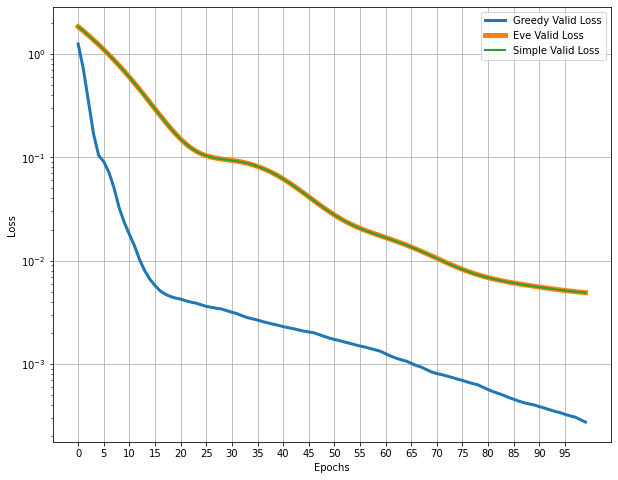

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

plt.plot(range(epochs), solver_loss, label="Greedy Valid Loss", linewidth=3)
plt.plot(range(epochs), eve, label="Eve Valid Loss", linewidth=5)
plt.plot(range(epochs), baseline, label="Simple Valid Loss", linewidth=2)
plt.xticks(ticks=range(0,100,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.grid()

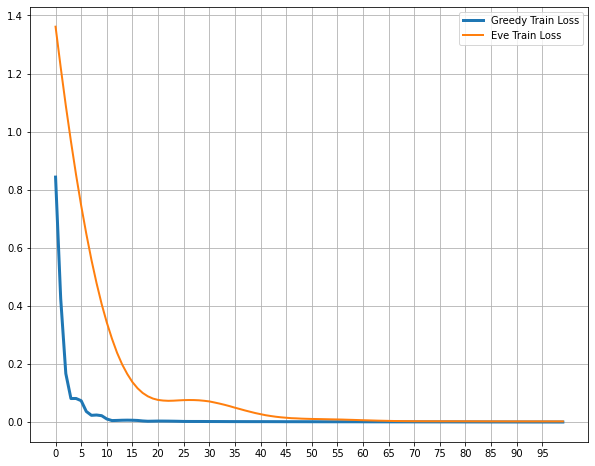

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

plt.plot(range(epochs), solver_loss, label="Greedy Train Loss", linewidth=3)
plt.plot(range(epochs), baseline, label="Eve Train Loss", linewidth=3)
plt.xticks(ticks=range(0,100,5))
plt.legend()
plt.grid()